# Beam Shape Analysis - Tapered Fibre, Full Radial Analysis

### What does this notebook do?

Experimental analysis
- Import Gaussian beamshape data and z values through pandas to np arrays
- Translate and transform Gaussians to reduce fitting parameters 
- Fit the beamshape Gaussians to a one parameter fit to find their waists, w
- Plot ws vs zsin(theta) and fit to (Two/ three parameter?) Fit
- Key: what is z0 and w0 experimentally for the fibre?

Theoretical Analysis
- Takes in wavelength, NA, core radius to calculate V number
- Use marcuse relation to find minumum waist
- Comparison?

## Import all useful libraries / tools

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.optimize import curve_fit
from os import listdir
import scipy

from lvl4_functions import *

## Import Data

In [2]:
# Define useful path to data
globalpath = "C:/Users/abiga/OneDrive - Durham University/1. Fourth Year/1. Project/Memory Stick Backup/Confocal Work/2024-02-14/Afternoon/Data-Red/"

In [3]:
# Import data
distances, amplitudes = import_data(globalpath)

['DL_12.csv', 'DL_13.csv', 'DL_14.csv', 'DL_15.csv', 'DL_16.csv', 'DL_17.csv', 'DL_18.csv', 'DL_19.csv', 'DL_20.csv', 'DL_24.csv', 'DL_25.csv', 'DL_26.csv', 'DL_27.csv', 'DR_12.csv', 'DR_13.csv', 'DR_14.csv', 'DR_15.csv', 'DR_16.csv', 'DR_17.csv', 'DR_18.csv', 'DR_19.csv', 'DR_20.csv', 'DR_24.csv', 'DR_25.csv', 'DR_26.csv', 'DR_27.csv', 'H_12.csv', 'H_13.csv', 'H_14.csv', 'H_15.csv', 'H_16.csv', 'H_17.csv', 'H_18.csv', 'H_19.csv', 'H_20.csv', 'H_24.csv', 'H_25.csv', 'H_26.csv', 'H_27.csv', 'V_12.csv', 'V_13.csv', 'V_14.csv', 'V_15.csv', 'V_16.csv', 'V_17.csv', 'V_18.csv', 'V_19.csv', 'V_20.csv', 'V_24.csv', 'V_25.csv', 'V_26.csv', 'V_27.csv']


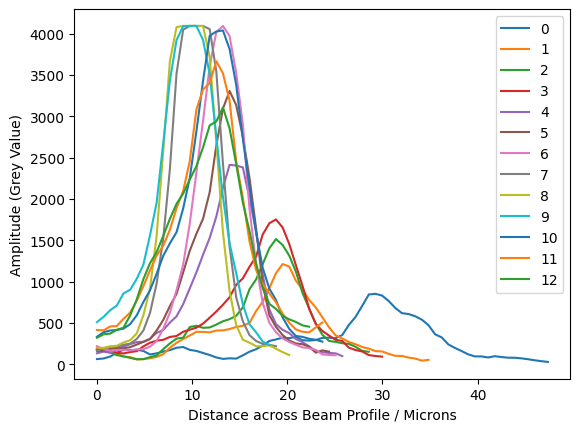

In [4]:
# Define how many data points we have. 'data size'
ds = 13

# Quick plot of raw data
for i in range(ds):
    plt.plot(distances[i+ds], amplitudes[i+ds], label = '{}'.format(i))

plt.legend()

plt.xlabel('Distance across Beam Profile / Microns')
plt.ylabel('Amplitude (Grey Value)')

plt.show()

## Normalise, cut down data

In [5]:
all_distances, all_amps = data_trim(distances, amplitudes, 10000000)

## Errors - for above normalised Gaussians

In [6]:
''' Error on cross sectional distance'''
# Scale says ~4.3055 pixels / microns therefore 0.232 microns / pixel
# so lets set error as 0.2 microns

all_distances_errors = []

for i in range(len(all_distances)):
    all_distances_errors.append(np.ones(np.size(all_distances[i]))*0.2) # takes into account different sized data sets

''' Error on amplitude '''
# Grey value resolution = 1
# But 12 bit image = 2^12 = 4096 available 'colours'
# Say 10% accuracy

all_amps_errors = []

for i in range(len(all_amps)):
    err = 40.96 / np.max(amplitudes[i])
    all_amps_errors.append(np.ones(np.size(all_amps[i]))*err) # takes into account different sized data sets

Plot Normalised Gaussian Curves with Errors

In [7]:
# Plot of a far field 'Gaussian' - is this a TEM10 mode?
# plt.errorbar(all_distances[-1], all_amps[-1], xerr=all_distances_errors[-1],yerr=all_amps_errors[-1])

## Fit Data

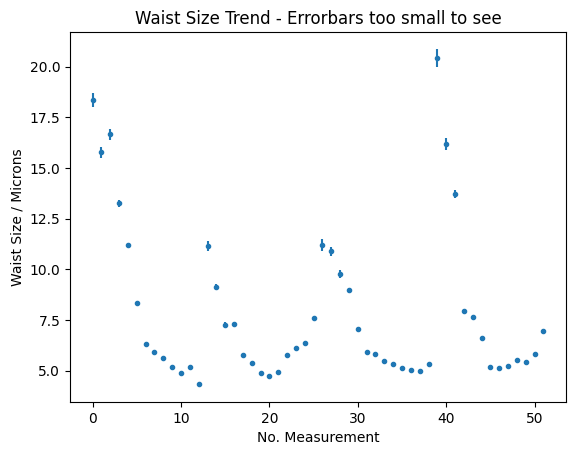

In [16]:
# Create some empty arrays to store values of interest
params_ = np.zeros((len(all_distances),3))
y_fits = [] # NB: this has to be a list due to different sized arrays sitting in it
params_errs_ = np.zeros((len(all_distances),3))
chi_red_array = np.zeros(len(all_distances))

# Populate initial guess array - important to change per data set!!
initial_guesses = np.zeros((len(all_distances),3))
initial_guesses[:,0] = 20
initial_guesses[9,0] = 5
initial_guesses[:,1] = 6
initial_guesses[:,2] = 1
initial_guesses[1,1] = 10
initial_guesses[17,1] = 10
initial_guesses[18,1] = 10
initial_guesses[9,0] = 20
initial_guesses[38,0] = 20
initial_guesses[43,0] = 20
initial_guesses[45,0] = 20
# initial_guesses[58,0] = 20
# initial_guesses[68,0] = 20
# initial_guesses[14:,1] = 50
# initial_guesses[0,0] = 0.2

for i in range(len(all_distances)):
    singlefit, params_[i], params_errs_[i], chi_red_array[i] = fit_labs(all_distances[i],all_amps[i], all_amps_errors[i], Gauss, initial_guesses[i])
    y_fits.append(singlefit)

waists = params_[:,0]
waists_errs = params_errs_[:,0]
# print(waists)
# print(len(waists))
# print(waists_errs)

waists[9] = np.abs(waists[9])

# Plot waist trend 
plt.errorbar(np.arange(len(all_distances)),waists, yerr = waists_errs, linestyle = '', marker = 'o', ms = 3)
plt.xlabel('No. Measurement')
plt.ylabel('Waist Size / Microns')
plt.title('Waist Size Trend - Errorbars too small to see')

for i in range(len(waists)):
    if waists[i] < 0:
        print(i, waists[i])

[ 5.18204121  7.47698224 27.32643362]


Text(0, 0.5, 'Normalised Amplitude')

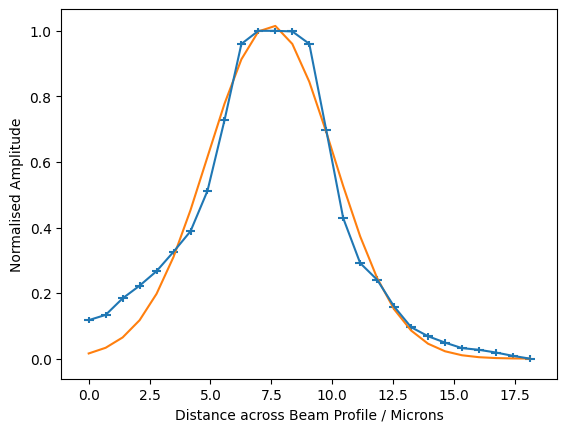

In [17]:
t = 9
plt.errorbar(all_distances[t], all_amps[t], xerr=all_distances_errors[t],yerr=all_amps_errors[t])
plt.plot(all_distances[t],y_fits[t])
print(params_[t])

plt.xlabel('Distance across Beam Profile / Microns')
plt.ylabel('Normalised Amplitude')

In [18]:
''' Split waist fits into vertical and horizontal measurements and take average'''

dl_waists = waists[0:ds]
dr_waists = waists[ds:2*ds]
h_waists = waists[2*ds:3*ds]
v_waists = waists[3*ds:]

dl_waists_errs = waists_errs[0:ds]
dr_waists_errs = waists_errs[ds:2*ds]
h_waists_errs = waists_errs[2*ds:3*ds]
v_waists_errs = waists_errs[3*ds:]

waists_array = np.array([dl_waists, dr_waists, h_waists,v_waists]) 
mean_waists = np.mean(waists_array, axis = 0)
std_waists = np.std(np.array(waists_array), axis = 0) / np.sqrt(np.shape(waists_array)[0])
print(mean_waists, std_waists)

[15.27845774 12.99077314 11.85895161  9.37669504  7.92703739  6.56890727
  5.54805543  5.3191126   5.27816447  5.40623458  5.36119393  5.59076167
  6.05404737] [2.08779231 1.52567735 1.80113543 1.15794246 1.00289579 0.55522423
 0.28450488 0.21367464 0.13199567 0.12892356 0.24143908 0.2692553
 0.64450292]


## Calculating Z values and Plotting Waist size against Z

In [23]:
# Define Global Path for where 'z' values are stored
z_path = 'C:/Users/abiga/OneDrive - Durham University/1. Fourth Year/1. Project/Memory Stick Backup/Confocal Work/2024-02-14/Afternoon/Data-Red/zs.csv'

# Import as dataframe
df_lengths = pd.read_csv(z_path)

# Convert to array. Called 'lengths' as this isnt the z values yet
lengths = np.array(df_lengths['zs'])

# Take error as confocal z stack resolution ie 0.1
lengths_errs = np.ones(len(lengths))*0.1

In [25]:
print(lengths)
print(len(lengths))

[-40.5 -37.8 -35.1 -32.4 -29.7 -27.  -24.3 -21.6 -18.9  -8.1  -5.4  -2.7
   0. ]
13


This 'lengths' value MIGHT need to be multiplied by cos theta? Where theta is angle of elevation of the fibre... but won't do this yet.

## Fit Waists vs Z

In [26]:
# Need wavelength of light to calc. Rayleigh Range (in microns)
wavelength = 0.635
wavelength_err = 0.005 # according to online spec (THORLABS CPS405)

Angle of elevation

<ErrorbarContainer object of 3 artists>

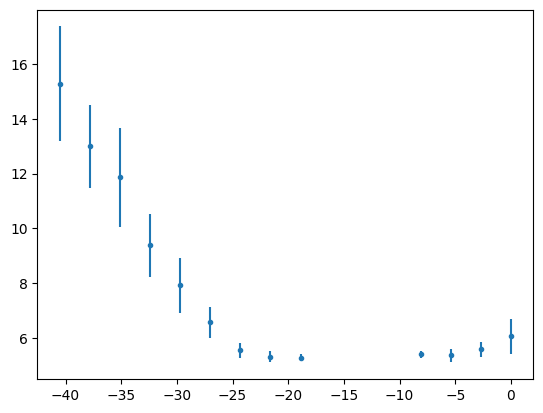

In [27]:
# online protractor at https://www.ginifab.com/feeds/angle_measurement/ 
# NB: see image 'C:\Users\abiga\OneDrive - Durham University\1. Fourth Year\1. Project\1. Data Analysis\Christmas Report\Cleaved-2\Cleaved - fibre- pics\cleaved_elev_angle'

# A plot of waists vs z
plt.errorbar(lengths, mean_waists, yerr = std_waists, linestyle = '', marker = 'o', ms = 3)


Fit

In [32]:
waist_fit1, params1, params_errs1, chisqu_WvsZ1 = fit_labs(lengths[0:9], mean_waists[0:9], std_waists[0:9], WvsZ, np.array([5,1,2]))
w01, z01,RR1= params1
w0_err1, z0_err1,RR_err1 = params_errs1

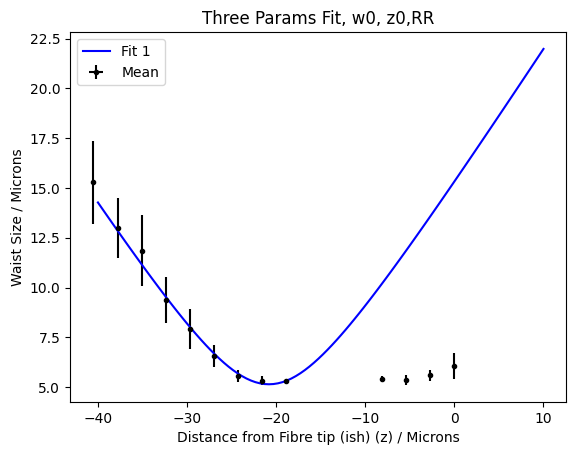

In [33]:
# Plot waists vs Z:
plt.errorbar(lengths, mean_waists, xerr = lengths_errs, yerr = std_waists, linestyle = '', marker = 'o', ms = 3, color = 'k',label = 'Mean')
plt.plot(np.linspace(-40,10,100), WvsZ(np.linspace(-40,10,100), w01, z01,RR1), color = 'blue', label = 'Fit 1')

# plt.errorbar(lengths, h_waists, yerr = h_waists_errs, linestyle = '', marker = 'o', ms = 3, label = 'Horizontal')
# plt.errorbar(lengths, dl_waists, yerr = dl_waists_errs, linestyle = '', marker = 'o', ms = 3, label = 'L Diagonal')
# plt.errorbar(lengths, dr_waists, yerr = dr_waists_errs, linestyle = '', marker = 'o', ms = 3, label = 'R Diagonal')
# plt.errorbar(lengths, v_waists, yerr = v_waists_errs, linestyle = '', marker = 'o', ms = 3, label = 'Vertical')

plt.xlabel('Distance from Fibre tip (ish) (z) / Microns')
plt.ylabel('Waist Size / Microns')
plt.title('Three Params Fit, w0, z0,RR')
plt.legend()

In [34]:
print('The minimum waist is {} pm {}'.format(w01, w0_err1))
print('The distance from the smallest z measurement to the minimum waist is {} pm {}'.format(z01, z0_err1))
#print('The weird systematic error Y is {} pm {}'.format(Y0, Y0_err))
print('The Rayleigh Range is {} pm {}.'.format(RR1,RR_err1))
print('The reduced chi squared value of this fit is {}'.format(chisqu_WvsZ1))

The minimum waist is 5.1380154744939714 pm 0.12486719520638939
The distance from the smallest z measurement to the minimum waist is -20.810326794644194 pm 0.6140860667252632
The Rayleigh Range is 7.404615808664074 pm 0.8056841276880745.
The reduced chi squared value of this fit is 0.185219540557904


In [ ]:
print('The wavelength check in nanometres is {} nm'.format(wavelength_check(w01,RR1)))
print('This is approx. {}x the actual wavelength'.format( wavelength_check(w01,RR1) / (wavelength*10**3)))

The wavelength check in nanometres is 6789.8991095183765 nm
This is approx. 10.692754503178545x the actual wavelength


## Now Move Graph so waist min is at z = 0

In [ ]:
# horizontal axis with min fitted waist set to zero
zs_0 = zs - z0
zs_0_err = np.sqrt(zs_err**2 + z0_err**2)

# z value at which fibre end occurs
z_end = zs_0[0] - 4

z_end_err = np.sqrt(zs_0_err[0]**2 + 1**2) # error on 4 measurement of 1 micron - high!

print('The fibre end is at z value {} pm {}'.format(z_end,z_end_err))
z_end = np.round_(z_end, decimals = 0)
z_end_err = np.round_(z_end_err, decimals = 0)
print('The fibre end is at z value {} pm {}'.format(z_end,z_end_err))

# Residuals 
wz_res = norm_residuals(zs,waists_comp,waists_comp_err,WvsZ,params)

NameError: name 'zs' is not defined

In [ ]:
# Create Figure
fig, ((ax1,ax3),(ax2,ax4)) = plt.subplots(2,2,height_ratios=(6,1), width_ratios=(6,1), figsize = (8,5))

# Font Settings
font1 = mpl.font_manager.FontProperties(family='Times New Roman',
style='normal', size=12)

# Kill dead plots
ax3.axis('off')
# Kill spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

# Plot waists vs Z:
ax1.errorbar(zs_0, waists_comp, xerr = zs_0_err, yerr = waists_comp_err, color = 'k', linestyle = '', marker = 'o', ms = 3, label = 'Data')
ax1.plot(np.linspace(-20,120,100) - z0, WvsZ(np.linspace(-20,120,100), w0, z0,RR), color = 'navy', label = 'Fit')

# Plot vertical fill line of where fibre end is
ax1.fill_betweenx(y=[5,25],x1=[-1,-1] , x2=[1, 1], color = 'k', alpha = 0.6, label = 'Fibre End')

# Residuals
ax2.errorbar(zs_0,wz_res,color = 'k', linestyle = '', marker = 'o', ms = 3)
ax2.errorbar([-8,120], [0,0], color = 'grey', linestyle = 'dotted')

# Histogram
mean, stderr, sorted_res, dist = histogram_plot(wz_res)
ax4.plot(dist, sorted_res, color = 'black')
ax4.hist(sorted_res, density = True, orientation = 'horizontal', color = 'grey', bins = 4)

# Axis labels
ax2.set_xlabel('Distance from Waist Minimum (z) / microns', font = 'Times New Roman', fontsize = 16)
ax1.set_ylabel('Waist Size / Microns', font = 'Times New Roman', fontsize = 16)
ax1.legend(prop = font1, loc = 'lower right')
ax4.set_xlabel('Freq. Density      ', font = 'Times New Roman', fontsize = 12)

ax1.set_xlim(-10,120)
ax2.set_xlim(-10,120)

#Get Rid of Ticks
ax4.set_xticks(ticks = [], labels = [], fontfamily = 'Times New Roman', fontsize = 10)

# Make visible ticks times new roman
ax1.set_xticks(ticks = np.arange(0,130,20), labels = np.arange(0,130,20), fontfamily = 'Times New Roman', fontsize = 11)
ax2.set_xticks(ticks = np.arange(0,130,20), labels = np.arange(0,130,20), fontfamily = 'Times New Roman', fontsize = 11)

ax1.set_yticks(ticks = np.arange(5,26,2.5), labels = np.round_(np.arange(5,26,2.5), decimals = 1), fontfamily = 'Times New Roman', fontsize = 11)
ax2.set_yticks(ticks = np.arange(-5,6,5), labels = np.round_(np.arange(-5,6,5), decimals = 1), fontfamily = 'Times New Roman', fontsize = 11)
ax4.set_yticks(ticks = np.arange(-5,6,5), labels = np.round_(np.arange(-5,6,5), decimals = 1), fontfamily = 'Times New Roman', fontsize = 11)

In [ ]:
print('The minimum waist is {} pm {}'.format(w0, w0_err))
print('The distance from the first measurement to the minimum waist is {} pm {}'.format(z0, z0_err))
#print('The weird systematic error Y is {} pm {}'.format(Y0, Y0_err))
print('The Rayleigh Range is {} pm {}.'.format(RR,RR_err))
print('The fibre end is at z value {} pm {}'.format(z_end,z_end_err))

In [ ]:
print(chisqu_WvsZ)
print(mean)
print(stderr)

Saving the important info in an array like:
x values
x errs
y values
y errs
residuals 

Second array:
w0, w0err
z0,z0_err
RR, RRerr
z_end, z_end_err

In [ ]:
# np.save('graph_cleaved.npy', np.array([zs_0, zs_0_err, waists_comp, waists_comp_err, wz_res]))
# np.save('params_cleaved.npy', np.array([w0,w0_err,z0, z0_err, RR, RR_err, z_end, z_end_err]))

## Comparison to Experiment - Ray Optics Model

Find k0 and define constants 

In [ ]:
# Defining Parameters of set-up
# info about fibre from 35m cable:
''' https://www.thorlabs.com/drawings/b4627de8c1f781cd-1251149A-D70E-815D-5BD8491D7FDA5B7B/PM1550-HP-SpecSheet.pdf '''

NA = 0.14 # numerical aperture 
NA_err = 0.01

k0 = find_k(wavelength)
k0_err = np.abs(find_k(wavelength+wavelength_err) - k0)
print(k0, k0_err)

a = 9.2e-6 / 2 # core radius, in metres 
a_err = 0.1e-6 / 2 

Find V_no and its error

In [ ]:
V_no = V_number(NA, k0, a)

EC_NA = np.abs(V_number(NA+NA_err, k0, a) - V_no)
EC_k0 = np.abs(V_number(NA, k0+k0_err, a)- V_no)
EC_a = np.abs(V_number(NA, k0, a+a_err) - V_no)

V_no_err = np.sqrt(EC_NA**2 + EC_k0**2 + EC_a**2)

In [ ]:
print('The predicted V no is {} pm {}'.format(V_no, V_no_err))

Using the Marcuse relation to compute theoretical minimum waist from V number and core radius

In [ ]:
w0_theory = marcuse(V_no,a)

# error on w0
cont_V_no = np.abs(marcuse(V_no+V_no_err,a) - w0_theory)
cont_a = np.abs(marcuse(V_no,a+a_err) - w0_theory)

w0_theory_err = np.sqrt(cont_V_no**2 + cont_a**2)

In [ ]:
print('The predicted minimum waist using the ray optics model is {} pm {} microns'.format(w0_theory,w0_theory_err))

## Report Plot - Did the Fibre taper as expected?

In [ ]:
# Import Data from measure function 

measure_data_path = 'C:/Users/abiga/OneDrive - Durham University/1. Fourth Year/1. Project/1. Data Analysis/Christmas Report/Fibre2-30-11/measure_fn.xlsx'

measure_df = pd.read_excel(measure_data_path)

In [ ]:
# Convert to Array 
diameter = np.array(measure_df['diam_x'])*10**3 # microns
position = np.array(measure_df['position']) - 5

# Theoretical Trend
theo_position = np.arange(-5,5.1,0.1)         
print(diameter) 

# Define Lines

def pos(x):
    return 56.25*x -15.625

def neg(x):
    return -56.25*x -15.625

def const(x):
    return np.ones(x.size)*12.5

neg_bit = np.linspace(-2.5,-0.5,100)
pos_bit = np.linspace(0.5,2.5,100)
const_bit = np.linspace(-0.5,0.5,100)

fig0, ax = plt.subplots(figsize = (10,5))

ax.errorbar(position, diameter, color = 'k', alpha = 0.7, linestyle = '-', marker = 'o', ms = 1, label = 'Measured Diameter')
ax.plot(neg_bit, neg(neg_bit), color = 'blue')
ax.plot(pos_bit, pos(pos_bit), color = 'blue')
ax.plot(const_bit, const(const_bit), color = 'blue')
ax.plot(np.linspace(-5,-2.5,100), np.ones(np.linspace(-5,-2.5,100).size)*125, color = 'blue')
ax.plot(np.linspace(2.5,5,100), np.ones(np.linspace(-5,-2.5,100).size)*125, color = 'blue', label = 'Machine Set Diameter')
ax.legend(prop = mpl.font_manager.FontProperties(family='Times New Roman',
style='normal', size=14))

ax.set_xlabel('Position Along Fibre / mm', font = 'Times New Roman', fontsize = 18)
ax.set_ylabel('Fibre Diameter / microns', font = 'Times New Roman', fontsize = 18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks(ticks = np.arange(0,152,25), labels = np.round_(np.arange(0,152,25), decimals = 1), fontfamily = 'Times New Roman', fontsize = 12)
ax.set_xticks(ticks = np.arange(-5,6,2.5), labels = np.arange(-5,6,2.5), fontfamily = 'Times New Roman', fontsize = 12)